In [97]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

from time import time

## Order 1.5 Strong Itô-Taylor scheme

At the end of the last lecture, we looked briefly at the order 1.5 strong Itô-Taylor scheme (Kloeden & Platen, p. 351-356):

\begin{align}
X_{n+1} = X_n &+ a \, \Delta t + b \, \Delta W_n + \frac{1}{2}b b'\big( (\Delta W_n)^2 - \Delta t\big) \\
&+ a'b\Delta Z_n + \frac{1}{2}\left(aa' + \frac{1}{2}b^2 a''\right) \Delta t^2 \\
&+ \left(ab' + \frac{1}{2}b^2 b''\right)\big( \Delta W_n \Delta t - \Delta Z_n \big) \\
&+ \frac{1}{2}b\left( bb'' + (b')^2\right) \left(\frac{1}{3}\Delta W_n^2 - \Delta t\right) \Delta W_n.
\end{align}

Here, I have dropped the arguments to $a(X, t)$ and $b(X, t)$ for convenience, $a'$, $a''$, $b'$, and $b''$ are the  first and second derivatives of $a$ and $b$ with respect to $X$, and $\Delta Z_n$ is an additional random variable, which is correlated with $\Delta W_n$, with the properties

\begin{align}
\langle \Delta Z \rangle &= 0 \\
\langle \Delta Z^2 \rangle &= \frac{1}{3}\Delta t^3 \\
\langle \Delta Z \Delta W \rangle &= \frac{1}{2}\Delta t^2 
\end{align}

**Note:** According to Kloeden & Platen, this scheme is valid only for autonomous scalar equations. Autonomous means that $a$ and $b$ are not functions of time, and scalar means that $X$ is not a vector.

We will now look at how to implement this, beginning with the generation of correlated random numbers.

## Correlated random numbers

When we talk about two random variables being correlated, we usually mean that there is a (noisy) linear relationship between them. There are different ways of quantifying correlation, for example:
* Covariance
* Pearson correlation (normalised covariance)

Positive covariance (or Pearson correlation) means that when one variable is large, the other tends to be large, and vice versa. Negative covariance means that when one variable is large, the other tends to be small. And zero covariance means that the variables are not correlated.

Covariance of two random variables, $X$ and $Y$, is given by 
$$ \mathrm{cov}(X, Y) = \big\langle (X - \mu_X) (Y - \mu_Y) \big\rangle, $$
where $\mu_X$ and $\mu_Y$ are the mean (expectation value) of $X$ and $Y$ respectively. Note that if $\mu_X=0$ and $\mu_Y=0$, then the covariance is simply $\mathrm{cov}(X, Y) = \langle XY \rangle$.

Below we show a simple example of uncorrelated, positively correlated and negatively correlated random numbers.

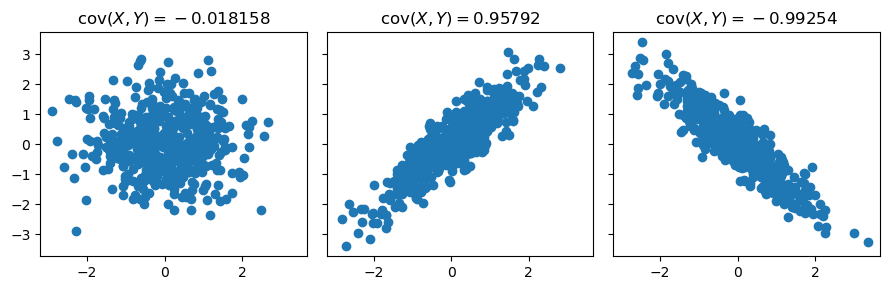

In [2]:
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(9,3))
N = 500


# Uncorrelated (and independent) random numbers
X = np.random.normal(size=N)
Y = np.random.normal(size=N)
cov = np.mean((X - np.mean(X))*(Y - np.mean(Y)))
ax[0].scatter(X, Y)
ax[0].set_title(f'$\mathrm{{cov}}(X, Y)={cov:.5}$')

# Positively correlated random numbers
X = np.random.normal(size=N)
Y = X + np.random.normal(scale=0.5, size=N)
cov = np.mean((X - np.mean(X))*(Y - np.mean(Y)))

ax[1].scatter(X, Y)
ax[1].set_title(f'$\mathrm{{cov}}(X, Y)={cov:.5}$')

# Negatively correlated random numbers
X = np.random.normal(size=N)
Y = -X + np.random.normal(scale=0.5, size=N)
cov = np.mean((X - np.mean(X))*(Y - np.mean(Y)))
ax[2].scatter(X, Y)
ax[2].set_title(f'$\mathrm{{cov}}(X, Y)={cov:.5}$')


plt.tight_layout()

## How to generate Gaussian random numbers with specified covariance for the order 1.5 strong Itô-Taylor scheme

Here we look at two options for generating the random numbers we need for this scheme.


### Method described in Kloeden & Platen (pp. 351-352)

Generate two independent random numbers, $U_1$ and $U_2$, both from a standard normal distribution, $\mathcal{N}(0, 1)$. Then $\Delta W$ and $\Delta Z$ can be calculated from these:

\begin{align}
\Delta W &= U_1 \sqrt{\Delta t} \\
\Delta Z &= \frac{1}{2} \Delta t^{3/2} \left(U_1 + \frac{1}{\sqrt{3}} U_2 \right)
\end{align}



### Specify covariance matrix and use numpy functions

$N$ correlated Gaussian random numbers, $X_1, X_2, \ldots, X_N$, may be described by an $N\times N$ matrix called the covariance matrix, where element $i, j$ is the covariance between $X_i$ and $X_j$. This covariance is given (as we saw above) by $\langle (X_i - \mu_i)(X_j - \mu_j) \rangle$, where $\mu_i = \langle X_i \rangle$ and $\mu_j = \langle X_j \rangle$. Note that the elements on the diagonal of the covariance matrix are the variances of the individual random numbers.

In our case, with two correlated numbers, $\Delta W$ and $\Delta Z$, both of which have zero mean, the covariance matrix becomes

$$ \left( \begin{array}{cc}
 \langle \Delta W^2 \rangle & \langle \Delta Z \Delta W \rangle \\
 \langle \Delta Z \Delta W \rangle & \langle \Delta Z^2 \rangle
 \end{array}
 \right).
$$

In the order 1.5 scheme, the values of all these elements are specified:

$$ \left( \begin{array}{cc}
 \Delta t & \frac{1}{2} \Delta t^2 \\
 \frac{1}{2} \Delta t^2 & \frac{1}{3} \Delta t^3
 \end{array}
 \right).
$$

We can pass this matrix directly to ```numpy.random.multivariate_normal``` to get Gaussian random numbers with the desired covariances.

Below, we implement and test both methods.

In [3]:
dt = 0.5
N = 10000

# Method from Kloeden & Platen:

U1, U2 = np.random.normal(loc=0, scale=1, size=(2, N))
dW = U1*np.sqrt(dt)
dZ = (1/2)*dt**(3/2) * (U1 + U2/np.sqrt(3))

print(f'var(dW)     = {np.var(dW):.5f}, should be {dt:.5f}')
print(f'var(dZ)     = {np.var(dZ):.5f}, should be {dt**3/3:.5f}')
print(f'cov(dW, dZ) = {np.mean(dW*dZ):.5f}, should be {dt**2/2:.5f}')

var(dW)     = 0.51272, should be 0.50000
var(dZ)     = 0.04242, should be 0.04167
cov(dW, dZ) = 0.12819, should be 0.12500


In [4]:
# Create covariance matrix
cov = np.array([
    [dt, dt**2/2],
    [dt**2/2, dt**3/3]
])

# Generate using library function
dW, dZ = np.random.multivariate_normal(mean=[0,0], cov=cov, size=(N)).T

print(f'var(dW)     = {np.var(dW):.5f}, should be {dt:.5f}')
print(f'var(dZ)     = {np.var(dZ):.5f}, should be {dt**3/3:.5f}')
print(f'cov(dW, dZ) = {np.mean(dW*dZ):.5f}, should be {dt**2/2:.5f}')

var(dW)     = 0.51229, should be 0.50000
var(dZ)     = 0.04211, should be 0.04167
cov(dW, dZ) = 0.12752, should be 0.12500


In [15]:
from autograd import elementwise_grad as egrad

def taylor15(X, t, dt, a, b, dW=None, dZ=None):
    if dW is None:
        cov = np.array([
            [dt, dt**2/2],
            [dt**2/2, dt**3/3]
        ])
        dW, dZ = np.random.multivariate_normal(mean=[0,0], cov=cov, size=X.shape).T
        
    # Define derivatives
    dadx = egrad(a)
    dbdx = egrad(b)
    da2dx2 = egrad(dadx)
    db2dx2 = egrad(dbdx)
    
    # Evaluate the functions and derivatives once
    a0 = a(X, t)
    b0 = b(X, t)
    a1 = dadx(X, t)
    b1 = dbdx(X, t)
    a2 = da2dx2(X, t)
    b2 = db2dx2(X, t)
    
    # code the different terms in a somewhat readable manner
    X_new = X + (
            a0*dt + b0*dW + 0.5*b0*b1*(dW**2 - dt)
          + a1*b0*dZ + 0.5*(a0*a1 + 0.5*b0**2*a2)*dt**2
          + (a0*b1 + 0.5*b0**2*b2)*(dW*dt - dZ)
          + 0.5*b0*(b0*b2 + b1**2)*(dW**2/3 - dt)*dW
            )
    
    return X_new

def solve_SDE(X0, tmax, dt, a, b, solver, W=None, Z=None):
    # A simple solve function (assumes dt evenly divides tmax)
    # Calculate number of timsteps (including 0 and tmax)
    Nt = int(tmax/dt) + 1
    # Confirm that dt evenly divides tmax (to reasonable precision):
    assert ((Nt-1)*dt - tmax) < 1e-14
    # If X0 is not an array, turn it into a 1-element array
    if not isinstance(X0, np.ndarray):
        X0 = np.array([X0])
    # Arrays to track solution
    X = np.zeros((Nt, *X0.shape))
    X[0,:] = X0
    t = 0
    for n in range(1, Nt):
        # Call solver, with pre-computed W if available
        if W is None:
            X[n,:] = solver(X[n-1,:], t, dt, a, b)
        else:
            # Obtain increment from pre-computed Wt
            if len(W.shape) > 1:
                dW = W[n,:] - W[n-1,:]
                if Z is not None:
                    dZ = Z[n,:] - Z[n-1,:]
            else:
                dW = W[n] - W[n-1]
                if Z is not None:
                    dZ = Z[n] - Z[n-1]
            if Z is None:
                X[n,:] = solver(X[n-1,:], t, dt, a, b, dW=dW)
            else:
                X[n,:] = solver(X[n-1,:], t, dt, a, b, dW=dW, dZ=dZ)
        t += dt
    return X

def solve_SDE_endpoints_only(X0, tmax, dt, a, b, solver, W=None, Z=None):
    # A simple solve function (assumes dt evenly divides tmax)
    # Calculate number of timsteps (including 0 and tmax)
    # This implementation stores only the latest timestep of X,
    # instead of the whole trajectory. This to save memory.
    Nt = int(tmax/dt) + 1
    # Confirm that dt evenly divides tmax (to reasonable precision):
    assert ((Nt-1)*dt - tmax) < 1e-14
    # If X0 is not an array, turn it into a 1-element array
    if not isinstance(X0, np.ndarray):
        X0 = np.array([X0])
    # Arrays to track solution
    X = X0.copy()
    t = 0
    for n in range(1, Nt):
        # Call solver, with pre-computed W if available
        if W is None:
            X = solver(X, t, dt, a, b)
        else:
            # Obtain increment from pre-computed Wt
            if len(W.shape) > 1:
                dW = W[n,:] - W[n-1,:]
                if Z is not None:
                    dZ = Z[n,:] - Z[n-1,:]
            else:
                dW = W[n] - W[n-1]
                if Z is not None:
                    dZ = Z[n] - Z[n-1]
            if Z is None:
                X = solver(X, t, dt, a, b, dW=dW)
            else:
                X = solver(X, t, dt, a, b, dW=dW, dZ=dZ)
        t += dt
    return X

### Strong convergence of order 1.5 Itô-Taylor scheme

Calculations took 2.247 seconds


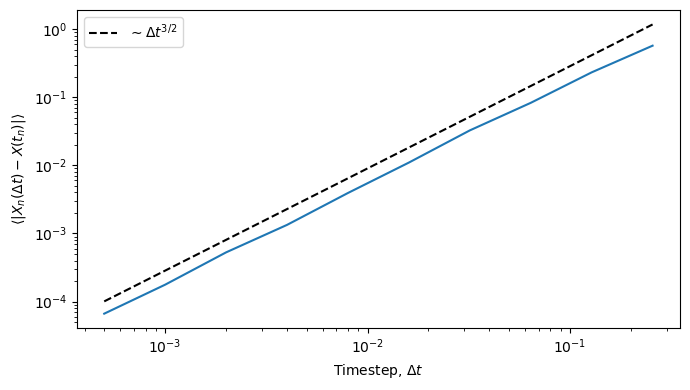

In [14]:
Np = 1000 # Number of realisations

# Highest resolution
dt_ref = 0.0005
Nt_ref = 2**12 + 1 # Note: Chosen so that we can subdivide it evenly many times
Tmax = dt_ref * (Nt_ref-1)
# Time
t_ref  = np.linspace(0, Tmax, Nt_ref)

# Generate realisations of W and Z
W_ref = np.zeros((Nt_ref, Np))
Z_ref = np.zeros((Nt_ref, Np))

cov = np.array([
    [dt_ref, dt_ref**2/2],
    [dt_ref**2/2, dt_ref**3/3]
])
dW_ref, dZ_ref = np.random.multivariate_normal(mean=[0,0], cov=cov, size=(Np, Nt_ref-1)).T

W_ref[1:,:] = np.cumsum( dW_ref, axis=0)
Z_ref[1:,:] = np.cumsum( dZ_ref, axis=0)

# Longer timesteps must be evenly dividable by dt_ref,
# using multiples of 2
multiples = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512])
error_list = np.zeros(len(multiples))
timesteps = dt_ref*multiples

# Parameters of SDE to solve
a_ = 1.0
b_ = 1.0
X0_ = 1.0
X0 = X0_ * np.ones(Np)

# Implementing a and b as functions of X and t,
# for consistency with the general solver
def a(X, t):
    return a_ * X

def b(X, t):
    return b_ * X


# Analytical solution
X_sol = X0_ * np.exp((a_-b_**2/2)*t_ref[-1] + b_*W_ref[-1,:])

tic = time()
# Solve for the different resolutions and calculate errors
for i, multi in enumerate(multiples):
    # dt, a multiple of dt_ref
    dt = dt_ref * multi
    # W with resolution dt, obtained by extracting values of W_ref at different intervals
    W = W_ref[::multi,:]
    Z = Z_ref[::multi,:]
    # Pass to solver
    X = solve_SDE(X0, Tmax, dt, a, b, taylor15, W=W, Z=Z)

    # Average absolute error
    error_list[i] = np.mean(np.abs(X[-1,:] - X_sol))

toc = time()
print(f'Calculations took {toc-tic:.3f} seconds')

fig = plt.figure(figsize=(7,4))
plt.plot(timesteps, error_list)
plt.plot(timesteps, 9*timesteps**1.5, '--', c='k', label='$\sim \Delta t^{3/2}$')
plt.xlabel('Timestep, $\Delta t$')
plt.ylabel('$ \langle | X_n(\Delta t) - X(t_n) | \\rangle $')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()

### Weak convergence of order 1.5 Itô-Taylor scheme

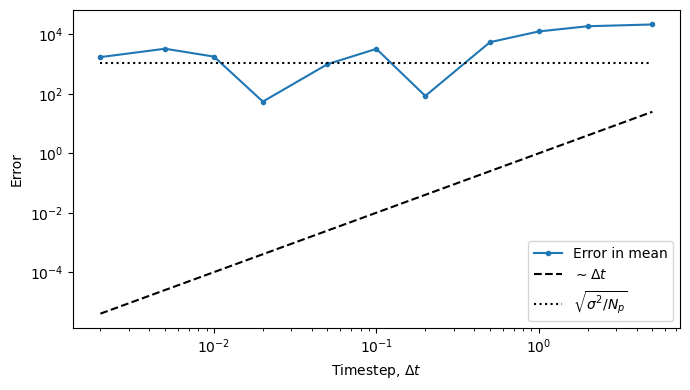

In [19]:
a_ = 1
b_ = 1
X0_ = 1

# Implementing a and b as functions of X and t,
# for consistency with the general solver
def a(X, t):
    return a_ * X

def b(X, t):
    return b_ * X

# Several initial values leads to several solutions
Np = 1000000
X0 = X0_ * np.ones(Np)
# Integration time
Tmax = 10
# timestep

# Solve for different timesteps, and calculate the mean and variance
timesteps = np.array([0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5])
mean_list = np.zeros_like(timesteps)
var_list  = np.zeros_like(timesteps)

for i, dt in enumerate(timesteps):
    # Using the version of the SDE solver that only returns endpoints,
    # to be able to run with more particles without running into memory issues
    X = solve_SDE_endpoints_only(X0, Tmax, dt, a, b, taylor15)
    mean_list[i] = np.mean(X)
    var_list[i] = np.var(X)

# Plot the difference between the observed and expected mean
mean = X0_*np.exp(a_*Tmax)

mean_error = np.abs(mean_list - mean)

fig = plt.figure(figsize=(7,4))
plt.plot(timesteps, mean_error, marker='.', label='Error in mean')

# Plot trendline indicating order of convergence
plt.plot(timesteps, timesteps**2, '--', c='k', label=('$\sim \Delta t$'))
# Plot "noise floor" (which is constant, independent of timestep)
plt.plot(timesteps, np.sqrt(var_list[0]/Np)*np.ones_like(timesteps), ':', c='k', label=('$\sqrt{\sigma^2/N_p}$'))

plt.xlabel('Timestep, $\Delta t$')
plt.ylabel('Error')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

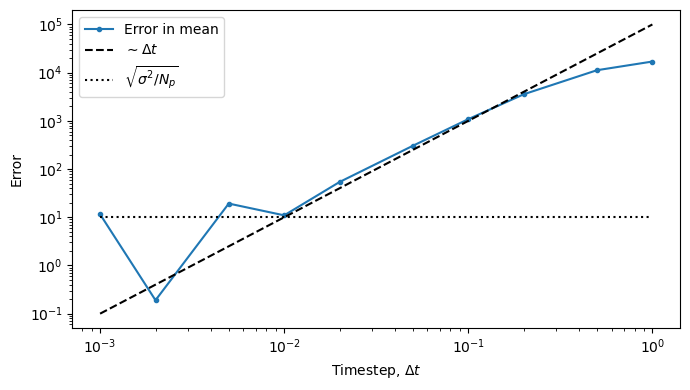

In [56]:
a_ = 2
b_ = 0.07
X0_ = 0.9

# Implementing a and b as functions of X and t,
# for consistency with the general solver
def a(X, t):
    return a_ * X

def b(X, t):
    return b_ * X

# Several initial values leads to several solutions
Np = 100000
X0 = X0_ * np.ones(Np)
# Integration time
Tmax = 5
# timestep

# Solve for different timesteps, and calculate the mean and variance
timesteps = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1])
mean_list = np.zeros_like(timesteps)
var_list  = np.zeros_like(timesteps)

for i, dt in enumerate(timesteps):
    # Using the version of the SDE solver that only returns endpoints,
    # to be able to run with more particles without running into memory issues
    X = solve_SDE(X0, Tmax, dt, a, b, taylor15)
    mean_list[i] = np.mean(X[-1,:])
    var_list[i] = np.var(X[-1,:])

# Plot the difference between the observed and expected mean
mean = X0_*np.exp(a_*Tmax)

mean_error = np.abs(mean_list - mean)

fig = plt.figure(figsize=(7,4))
plt.plot(timesteps, mean_error, marker='.', label='Error in mean')

# Plot trendline indicating order of convergence
plt.plot(timesteps, 1e5*timesteps**2, '--', c='k', label=('$\sim \Delta t^2$'))
# Plot "noise floor" (which is constant, independent of timestep)
plt.plot(timesteps, np.sqrt(var_list[0]/Np)*np.ones_like(timesteps), ':', c='k', label=('$\sqrt{\sigma^2/N_p}$'))

plt.xlabel('Timestep, $\Delta t$')
plt.ylabel('Error')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

## Second order Milstein scheme

This scheme is simpler than the order 1.5 Itô-Taylor scheme, with the same order of convergence in the weak sense (2), but without the order 1.5 in the strong sense.

\begin{align}
X_{n+1} = X_n &+ a \, \Delta t + b \, \Delta W_n + \frac{1}{2}b b'\big( \Delta W_n^2 - \Delta t\big) \\
&+ \frac{1}{2}\left(aa' + \frac{1}{2}b^2 a''\right) \Delta t^2 \\
&+ \frac{1}{2}\left(ab' + a'b + \frac{1}{2}b^2 b''\right)\Delta W_n \Delta t.
\end{align}

In [61]:
def milstein2(X, t, dt, a, b, dW=None):
    # Compute random numbers unless supplied as keyword argument
    if dW is None:
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=X.shape)        

    # Define derivatives
    dadx = egrad(a)
    dbdx = egrad(b)
    da2dx2 = egrad(dadx)
    db2dx2 = egrad(dbdx)
    
    # Evaluate the functions and derivatives once
    a0 = a(X, t)
    b0 = b(X, t)
    a1 = dadx(X, t)
    b1 = dbdx(X, t)
    a2 = da2dx2(X, t)
    b2 = db2dx2(X, t)
    
    # code the different terms in a somewhat readable manner
    X_new = X + (
            a0*dt + b0*dW + 0.5*b0*b1*(dW**2 - dt)
          + 0.5*(a0*a1 + 0.5*b0**2*a2)*dt**2
          + 0.5*(a0*b1 + a1*b0 + 0.5*b0**2*b2)*dW*dt
            )
    
    return X_new

Calculations took 2.278 seconds


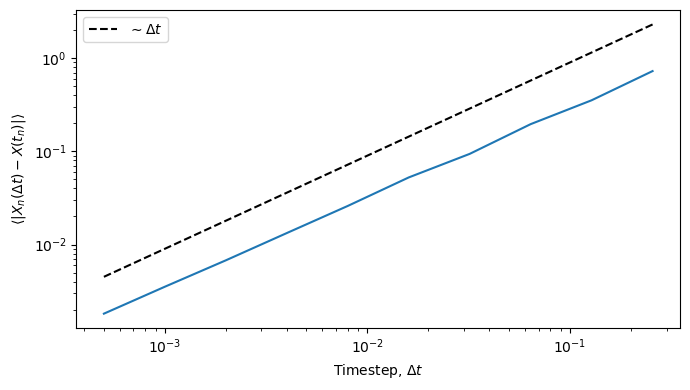

In [82]:
Np = 1000 # Number of realisations

# Highest resolution
dt_ref = 0.0005
Nt_ref = 2**12 + 1 # Note: Chosen so that we can subdivide it evenly many times
Tmax = dt_ref * (Nt_ref-1)
# Time
t_ref  = np.linspace(0, Tmax, Nt_ref)

# Generate realisations of W
W_ref = np.zeros((Nt_ref, Np))
dW_ref = np.random.normal(loc=0, scale=np.sqrt(dt_ref), size=(Nt_ref-1, Np))
W_ref[1:,:] = np.cumsum( dW_ref, axis=0)

# Longer timesteps must be evenly dividable by dt_ref,
# using multiples of 2
multiples = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512])
error_list = np.zeros(len(multiples))
timesteps = dt_ref*multiples

# Parameters of SDE to solve
a_ = 1.0
b_ = 1.0
X0_ = 1.0
X0 = X0_ * np.ones(Np)

# Implementing a and b as functions of X and t,
# for consistency with the general solver
def a(X, t):
    return a_ * X

def b(X, t):
    return b_ * X


# Analytical solution
X_sol = X0_ * np.exp((a_-b_**2/2)*t_ref[-1] + b_*W_ref[-1,:])

tic = time()
# Solve for the different resolutions and calculate errors
for i, multi in enumerate(multiples):
    # dt, a multiple of dt_ref
    dt = dt_ref * multi
    # W with resolution dt, obtained by extracting values of W_ref at different intervals
    W = W_ref[::multi,:]
    # Pass to solver
    X = solve_SDE(X0, Tmax, dt, a, b, milstein2, W=W)

    # Average absolute error
    error_list[i] = np.mean(np.abs(X[-1,:] - X_sol))

toc = time()
print(f'Calculations took {toc-tic:.3f} seconds')

fig = plt.figure(figsize=(7,4))
plt.plot(timesteps, error_list)
plt.plot(timesteps, 9*timesteps, '--', c='k', label='$\sim \Delta t$')
plt.xlabel('Timestep, $\Delta t$')
plt.ylabel('$ \langle | X_n(\Delta t) - X(t_n) | \\rangle $')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()

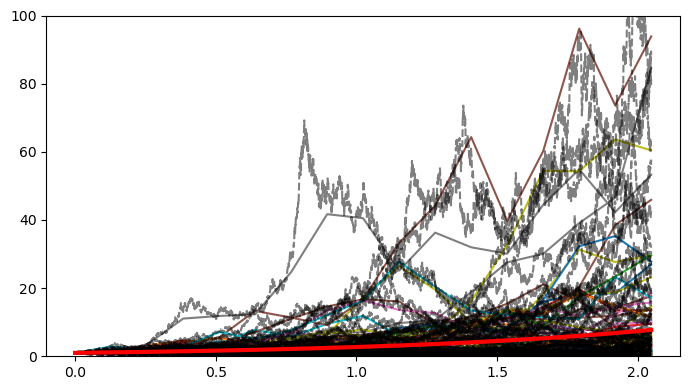

In [83]:
Np = 100 # Number of realisations

# Highest resolution
dt_ref = 0.0005
Nt_ref = 2**12 + 1 # Note: Chosen so that we can subdivide it evenly many times
Tmax = dt_ref * (Nt_ref-1)
# Time
t_ref  = np.linspace(0, Tmax, Nt_ref)

# Generate realisations of W
W_ref = np.zeros((Nt_ref, Np))
dW_ref = np.random.normal(loc=0, scale=np.sqrt(dt_ref), size=(Nt_ref-1, Np))
W_ref[1:,:] = np.cumsum( dW_ref, axis=0)

# Parameters of SDE to solve
a_ = 1.0
b_ = 1.0
X0_ = 1.0
X0 = X0_ * np.ones(Np)

# Implementing a and b as functions of X and t,
# for consistency with the general solver
def a(X, t):
    return a_ * X

def b(X, t):
    return b_ * X


# Analytical solution
X_sol = X0_ * np.exp((a_-b_**2/2)*t_ref[-1] + b_*W_ref[-1,:])

multi=256
# dt, a multiple of dt_ref
dt = dt_ref * multi
# W with resolution dt, obtained by extracting values of W_ref at different intervals
W = W_ref[::multi,:]
# Pass to solver
X = solve_SDE(X0, Tmax, dt, a, b, milstein2, W=W)


fig = plt.figure(figsize=(7,4))

plt.plot(t_ref[::multi], X)

X_sol = X0_ * np.exp((a_-b_**2/2)*t_ref[:,None] + b_*W_ref)
plt.plot(t_ref, X_sol, '--', c='k', alpha=0.5)

plt.plot(t_ref, X0_*np.exp(t_ref*a_), c='r', lw=3)

plt.ylim(0, 100)
plt.tight_layout()

# References

Kloeden & Platen (1992), _Numerical Solution of Stochastic Differential Equations_. https://link.springer.com/book/10.1007/978-3-662-12616-5